# <font color='#FF5733'>Group J regression Task: Predict song popularity

# <font color='#FF5733'>Steps & Contents</font> <a class="anchor" id="contents" ></a>

* [Intro - Business understanding](#business)
* [Executive Summary on results](#summary)
* [1 - Data Import](#import)
* [2 - Data understanding](#understanding)
* [3 - Data Preparation](#preparation)
* [3.1 - Feature Engineering](#engineering)
* [4 - Modelling, multiple](#model)
* [4.1 - Linear Model](#LR)
* [4.2 - Decision Tree](#DT)
* [4.3 - Neural Network with Random Search](#MLP)
* [4.4 - Random Forest](#RF)
* [5 - Evaluation](#evaluation)
* [5.1 - Linear Model](#EV_LR)
* [5.2 - Decision Tree](#EV_DT)
* [5.3 - Neural Network evaluation](#EV_MLP)
* [5.4 - Random Forest](#EV_RF)
* [6.0 - Overall evaluation](#overall)

# <font color='#FF5733'>Intro - Business understanding</font> <a class="anchor" id="business" ></a>



The task of this challenge is to predict the popularity of a song given specific features, as provided via Spotify API. <br>
According to the insights gained, we saw that popularity prediction can help to design a song production and scale up in Spotify recommendations system. <br>
The popularity index itself is not relevant in its whole scale. According to music producers, there are some thresholds that need to be achieved after 1 week of a song release, in order to be able to appear in the "release radar" (at least 20 in popularity) and "discovery weekly" (at least 50 in popularity). 
<br>

https://lodgecove.com/what-is-the-spotify-popularity-index/

Although this insight would shape drastically the task, the requirements is to build a regression model, to predict the whole range of popularity possible according to past data. <br>

# <font color='#FF5733'>Executive summary on results</font> <a class="anchor" id="summary" ></a>

After running multiple models, we couldn't find any model that gives us minimum good results. On average we found an R2 of 2-3% as variance explained by the models, and poor prediction accuracy. 

In the notebook is possible to observe models with the best performance, in terms of overfitting and R2. Neural Network seemed to provide a more robust fit, although poor in terms of variance. On the other hand, Random forest regression proved to be a good candidate, but prone to overfitting. 

All in all, we propose a full enrichment of the data in order to get better "results" in terms of popularity:

* artists name: if an artist is popular, the song will most likely be as well. Possible collaboration between two popular artists raise the probability even more.
* year of release: popularity should be compared on songs with same "maturity of release"
* genre: different genres have differnt potential to become popular and different features among the popular ones. A raggaeton song cannot have the same features of a white soul, and still be both positive
* extra features of the song, especially the chords and the structure of refrain and chorus
* summary of main lyrics contents

The latter is probably due because the most popular songs are related to the nature of the artist, genre, release date, among others variables instead of its loudness, intrumentalness and energy scores.


In [ ]:
!pip install category-encoders
# Loading packages
import os #operating system
import csv #open csv file
import numpy as np #work with arrays
import pandas as pd
# for specific colab data import
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt #visualizations
from ipywidgets import interact, interact_manual # interactive visuals
import seaborn as  sns #visualizations

## data manipulation
import category_encoders as ce
from sklearn import preprocessing #ML
from sklearn.model_selection import train_test_split

## modelling + evaluation
from sklearn import linear_model
from sklearn import metrics
from yellowbrick.model_selection import RFECV #visualizations for ML
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import random

from sklearn.ensemble import RandomForestRegressor

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 86 kB 779 kB/s 
Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color = '#FF5733'>1 - Data Import</font> <a class = "anchor" id = import></a>

[back to content](#contents)


In [ ]:
ds = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Mea project/songs_popularity.xlsx', engine='openpyxl')
# new line for normal notebook
#ds = pd.read_excel('song_popularity.xlsx', engine = 'openpyxl')

In [ ]:
ds.head(5)

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  originality  danceability  energy  instrumentalness  key  \
0      0.005520          NaN         0.496   0.682          0.000029    8   
1      0.010300          NaN         0.542   0.853          0.000000    3   
2      0.008170          NaN         0.737   0.463          0.447000    0   
3      0.026400          NaN         0.451   0.970          0.003550    0   
4      0.000954          NaN         0.447   0.766          0.000000   10   

   liveness  loudness  audio_mode  speechiness    tempo  time_signature  \
0    0.0589    -4.095           1       0.0294  167.060               4   
1    0.1080    -6.407           0       0.0498  105.256               4   
2    0.2550    -7.828           1       0.0792  123.881               4   
3    0.1020    -4.938           1       0.1070  122.444               4   
4    0.1130    -5.065           1       0.0313  172.011               4   

   audio_valence  
0          0.474  
1          0.370  
2          0.324  
3          0.198  
4          0.574

# <font color = '#FF5733'>2 - Data understanding</font> <a class = "anchor" id = understanding></a>

[back to content](#contents)

In [ ]:
ds.describe(include= 'all').T

count unique     top freq           mean           std  \
song_name           18835  13070  Better   21            NaN           NaN   
song_popularity   18835.0    NaN     NaN  NaN      52.991877     21.905654   
song_duration_ms  18835.0    NaN     NaN  NaN  218211.587576  59887.540566   
acousticness      18835.0    NaN     NaN  NaN       0.258539      0.288719   
originality        5742.0    NaN     NaN  NaN      50.679032      29.07375   
danceability      18835.0    NaN     NaN  NaN       0.633348      0.156723   
energy            18835.0    NaN     NaN  NaN       0.644995      0.214101   
instrumentalness  18829.0    NaN     NaN  NaN       0.080157      0.264622   
key               18835.0    NaN     NaN  NaN       5.289196      3.614595   
liveness          18835.0    NaN     NaN  NaN        0.17965      0.143984   
loudness          18835.0    NaN     NaN  NaN      -7.447435      3.827831   
audio_mode        18835.0    NaN     NaN  NaN       0.628139      0.483314   
speechiness       18835.0    NaN     NaN  NaN       0.102099      0.104378   
tempo             18835.0    NaN     NaN  NaN     121.073154     28.714456   
time_signature    18835.0    NaN     NaN  NaN       3.959119      0.298533   
audio_valence     18835.0    NaN     NaN  NaN       0.527967      0.244632   

                       min       25%       50%       75%        max  
song_name              NaN       NaN       NaN       NaN        NaN  
song_popularity        0.0      40.0      56.0      69.0      100.0  
song_duration_ms   12000.0  184339.5  211306.0  242844.0  1799346.0  
acousticness      0.000001    0.0241     0.132     0.424      0.996  
originality            1.0      26.0      52.0      76.0      100.0  
danceability           0.0     0.533     0.645     0.748      0.987  
energy             0.00107      0.51     0.674     0.815      0.999  
instrumentalness       0.0       0.0  0.000011   0.00259       10.0  
key                    0.0       2.0       5.0       8.0       11.0  
liveness            0.0109    0.0929     0.122     0.221      0.986  
loudness           -38.768    -9.044    -6.555    -4.908      1.585  
audio_mode             0.0       0.0       1.0       1.0        1.0  
speechiness            0.0    0.0378    0.0555     0.119      0.941  
tempo                  0.0    98.368   120.013   139.931    242.318  
time_signature         0.0       4.0       4.0       4.0        5.0  
audio_valence          0.0     0.335     0.527     0.725      0.984

## Main comments on first data inspection

 - There are 18835 songs, with 13070 of them named different. The most common name is "Better" and it repeats 21 times in the dataset. <br>
 - song_popularity goes between 0 and 100, and the average popularity is 52. It's the only variable non-numerical in the dataset. Surprisingly there are "0" values, which according to Musistax might be due to new releases for which there is still no index available (every 2 day update). https://musicstax.com/ <br>
 - song_duration_ms goes in between 12k and 1.799k, the high values (very long songs) seem to be outliers.<br>
 - originality ranks in between 1 and 100, and has more than 12K missing values (almost 70%) <br>
 - Most of the variables rank in between 0 and 1. <br>
 - instumentalness has probably outliers since the p75 is very different from the max value. Also, has a few missing values. <br>
 - loudness is a relevant variable to study in detail, since most of its values are negative, but the max is positive <br>
 - time signatures is for its majority = 4, so possibly droppable

In [ ]:
ds.isnull().sum()/len(ds.index)*100

#69% of the values from "originality" are missing
#0,03% of the values of instrumentalness are missing
#The rest of the dataset has no missing values

song_name            0.000000
song_popularity      0.000000
song_duration_ms     0.000000
acousticness         0.000000
originality         69.514202
danceability         0.000000
energy               0.000000
instrumentalness     0.031856
key                  0.000000
liveness             0.000000
loudness             0.000000
audio_mode           0.000000
speechiness          0.000000
tempo                0.000000
time_signature       0.000000
audio_valence        0.000000
dtype: float64

In [ ]:
ds.duplicated().sum()
## seems like at least 2006 rows are duplicated

2006

## Plotting

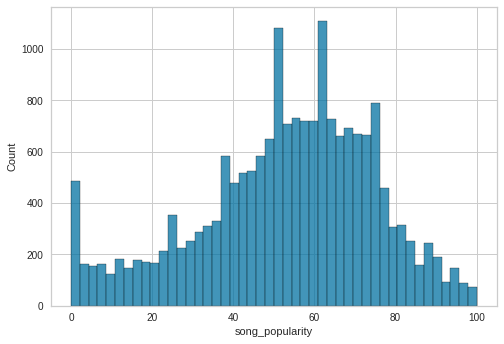

In [ ]:
sns.histplot(data = ds , x = 'song_popularity', palette= 'bright')

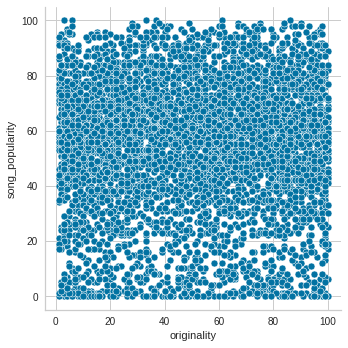

In [ ]:
sns.relplot(data = ds, x = 'originality', y = 'song_popularity')

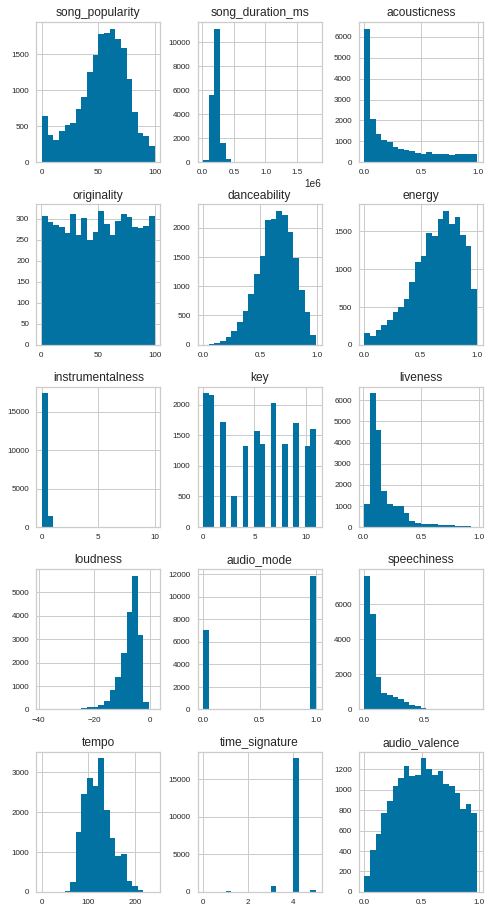

In [ ]:
#Visual Explorations for outliers in numerical variables
#Histograms for numerical variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=20, figsize=(8, 16), layout=(5, 3), xlabelsize=8, ylabelsize=8);

#song_popularity, danceability and tempo have a distribution similar to normal when plotted (TBC once we analyze each variable)
#instrumentalness, audio_mode and time_signature have peaks 
#song_duration_ms, instrumentalness, liveness, speechiness and time_signature seem to have outliers

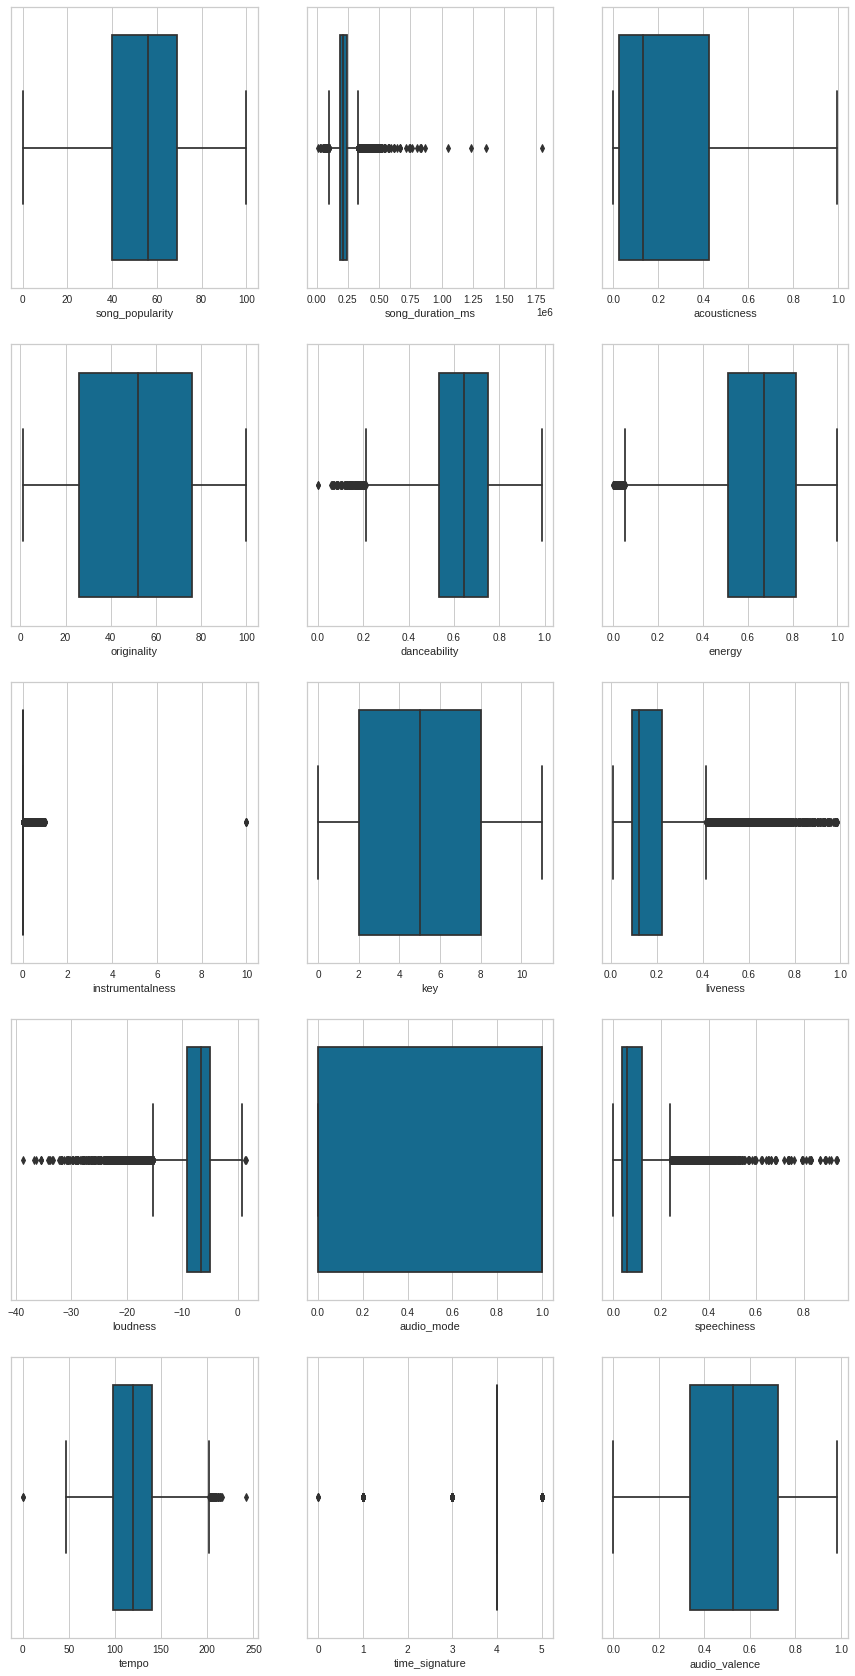

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(15, 30))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=ds[var], ax=subplot)
    
#Here we can confirm that the following variables seem to have outliers: song_duration_ms, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo and time_signature

In [ ]:
# Box Plot exploration

@interact

def plot_num(column = numerical):
    
    plt.figure(figsize=(8,6))
    return sns.boxplot(ds[column])

interactive(children=(Dropdown(description='column', options=('song_popularity', 'song_duration_ms', 'acoustic…

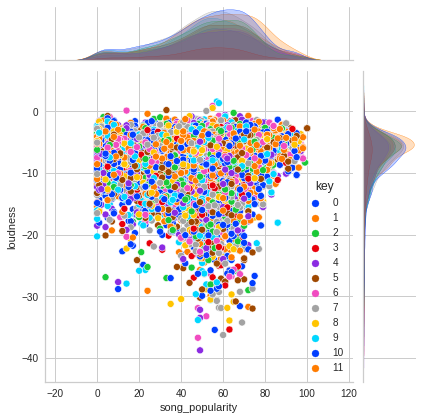

In [ ]:
sns.jointplot(data = ds, x = 'song_popularity', y = 'loudness' , hue = 'key', palette = 'bright')
# cannot find specific keys which are strictly connected to high popularity song

In [ ]:
## let summarize the common features values that most popular songs have, in order to find some 
import plotly.express as px

df = ds.sort_values(by = 'song_popularity', ascending = False).loc[ds.song_popularity >= 85][[
        'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy','liveness',
       'loudness',  'speechiness', 'tempo','audio_valence']]
fig = px.parallel_coordinates(df, color="song_popularity",
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [ ]:
# Create copy of dataset enables us to experiment how the radar plot (based on mean of variables) would look like
# After creation of copy we use min max scaler to put variables that we wanna use on a same scale as the rest ones (varying between 0 and 1)

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

radar = ds.copy(deep=True)
min_max_scaler = MinMaxScaler()
radar[["tempo", "loudness"]] = min_max_scaler.fit_transform(radar[["tempo", "loudness"]])

In [ ]:
# Binning the songs into three categories based on ranking, in order to understand if there's any patterns for songs with similar popularity. 
# All groups have the same number of songs (equally binned)
radar['song_popularity_binning'] = pd.qcut(radar['song_popularity'], 3, labels=['low_popular', 'ok_popular', 'most_popular'])

In [ ]:
# Transfortmation for radar plotting 
# Each bin we call for a separate dataframe

ds_high = radar.apply(lambda row: row[radar['song_popularity_binning'].isin(['most_popular'])])
ds_medium = radar.apply(lambda row: row[radar['song_popularity_binning'].isin(['ok_popular'])])
ds_low = radar.apply(lambda row: row[radar['song_popularity_binning'].isin(['low_popular'])])


In [ ]:
# Extracting mean values for each dataset and creating just one row with mean values across 6 features. Later we merge to see direct mean comparisons of these features among 3 bins.

ds_high = pd.DataFrame(ds_high.mean().to_dict(),index=[ds_high.index.values[-1]])
ds_high = ds_high[['danceability', 'energy', 'acousticness', 'liveness','loudness','tempo','audio_valence']]
ds_high = ds_high.rename(index={18826: 'HIGH'})

ds_medium = pd.DataFrame(ds_medium.mean().to_dict(),index=[ds_medium.index.values[-1]])
ds_medium = ds_medium[['danceability', 'energy', 'acousticness', 'liveness','loudness','tempo','audio_valence']]
ds_medium = ds_medium.rename(index={18834: 'MEDIUM'})


ds_low = pd.DataFrame(ds_low.mean().to_dict(),index=[ds_low.index.values[-1]])
ds_low = ds_low[['danceability', 'energy', 'acousticness', 'liveness','loudness','tempo','audio_valence']]
ds_low = ds_low.rename( index={18832: 'LOW'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:
# Merging dataframes together, looking like a mean crosstab

mean_together = [ds_high, ds_medium, ds_low]
final_means = pd.concat(mean_together)
final_means

danceability    energy  acousticness  liveness  loudness     tempo  \
HIGH        0.656747  0.657584      0.216079  0.174218  0.794888  0.497858   
MEDIUM      0.621273  0.631331      0.283602  0.177239  0.765911  0.496867   
LOW         0.622657  0.646520      0.274738  0.187428  0.768211  0.504221   

        audio_valence  
HIGH         0.523402  
MEDIUM       0.512753  
LOW          0.547892

In [ ]:
# Manual insert of values into lists that enable us to create the visual radar plot of the final dataframe

subjects=['DANCE','ENERGY','ACCOUSTICNESS', 'LIVENESS','LOUDNESS','TEMPO','AUDIO_VALENCE']
high=[0.656747,0.657584,0.216079,0.174218,0.794888,0.497858,0.523402]
medium=[0.621273,0.631331,0.283602,0.177239,0.765911,0.496867,0.512753]
low=[0.622657,0.646520,0.274738,0.187428,0.768211,0.504221,0.547892]

In [ ]:
# Preparation of polar plot + completing full circle

angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

subjects.append(subjects[0])
high.append(high[0])
medium.append(medium[0])
low.append(low[0])

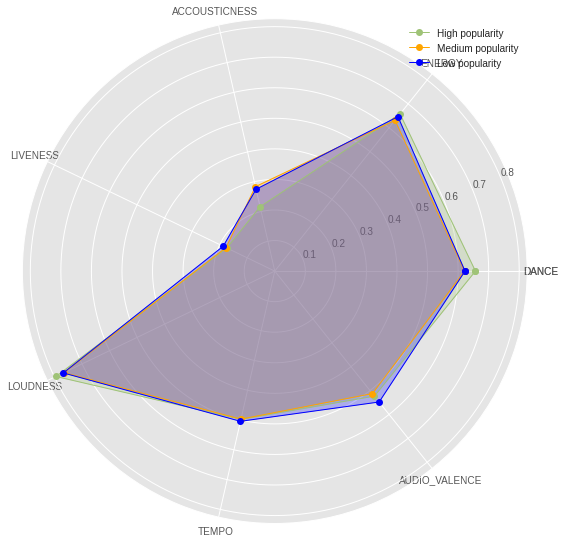

In [ ]:
# Final visualization code 

fig=plt.figure(figsize=(8,10))
ax=fig.add_subplot(111, polar=True)

#High Plot
ax.plot(angles,high, 'o-', color='g', linewidth=1, label='High popularity')
ax.fill(angles, high, alpha=0.25, color='g')
#Medium Plot
ax.plot(angles,medium, 'o-', color='orange', linewidth=1, label='Medium popularity')
ax.fill(angles, medium, alpha=0.25, color='orange')
#Low Plot
ax.plot(angles,low, 'o-', color='blue', linewidth=1, label='Low popularity')
ax.fill(angles, low, alpha=0.25, color='blue')

ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## Main comments <br>
 -  the most popular song are usually between 200K ms & 300K ms long <br>
 -  very low level of acouticness <br>
 -  over 60% of danceabililty 
 -  above 60% energy and around [-4, -6] loudness
 -  tempo between 90 and 160 bpm (possibly depending on genre)
 * there is no clear different pattern between songs with different level of popularity. Radar plot shows that there is not significant variable based on which the prediction could be based on.

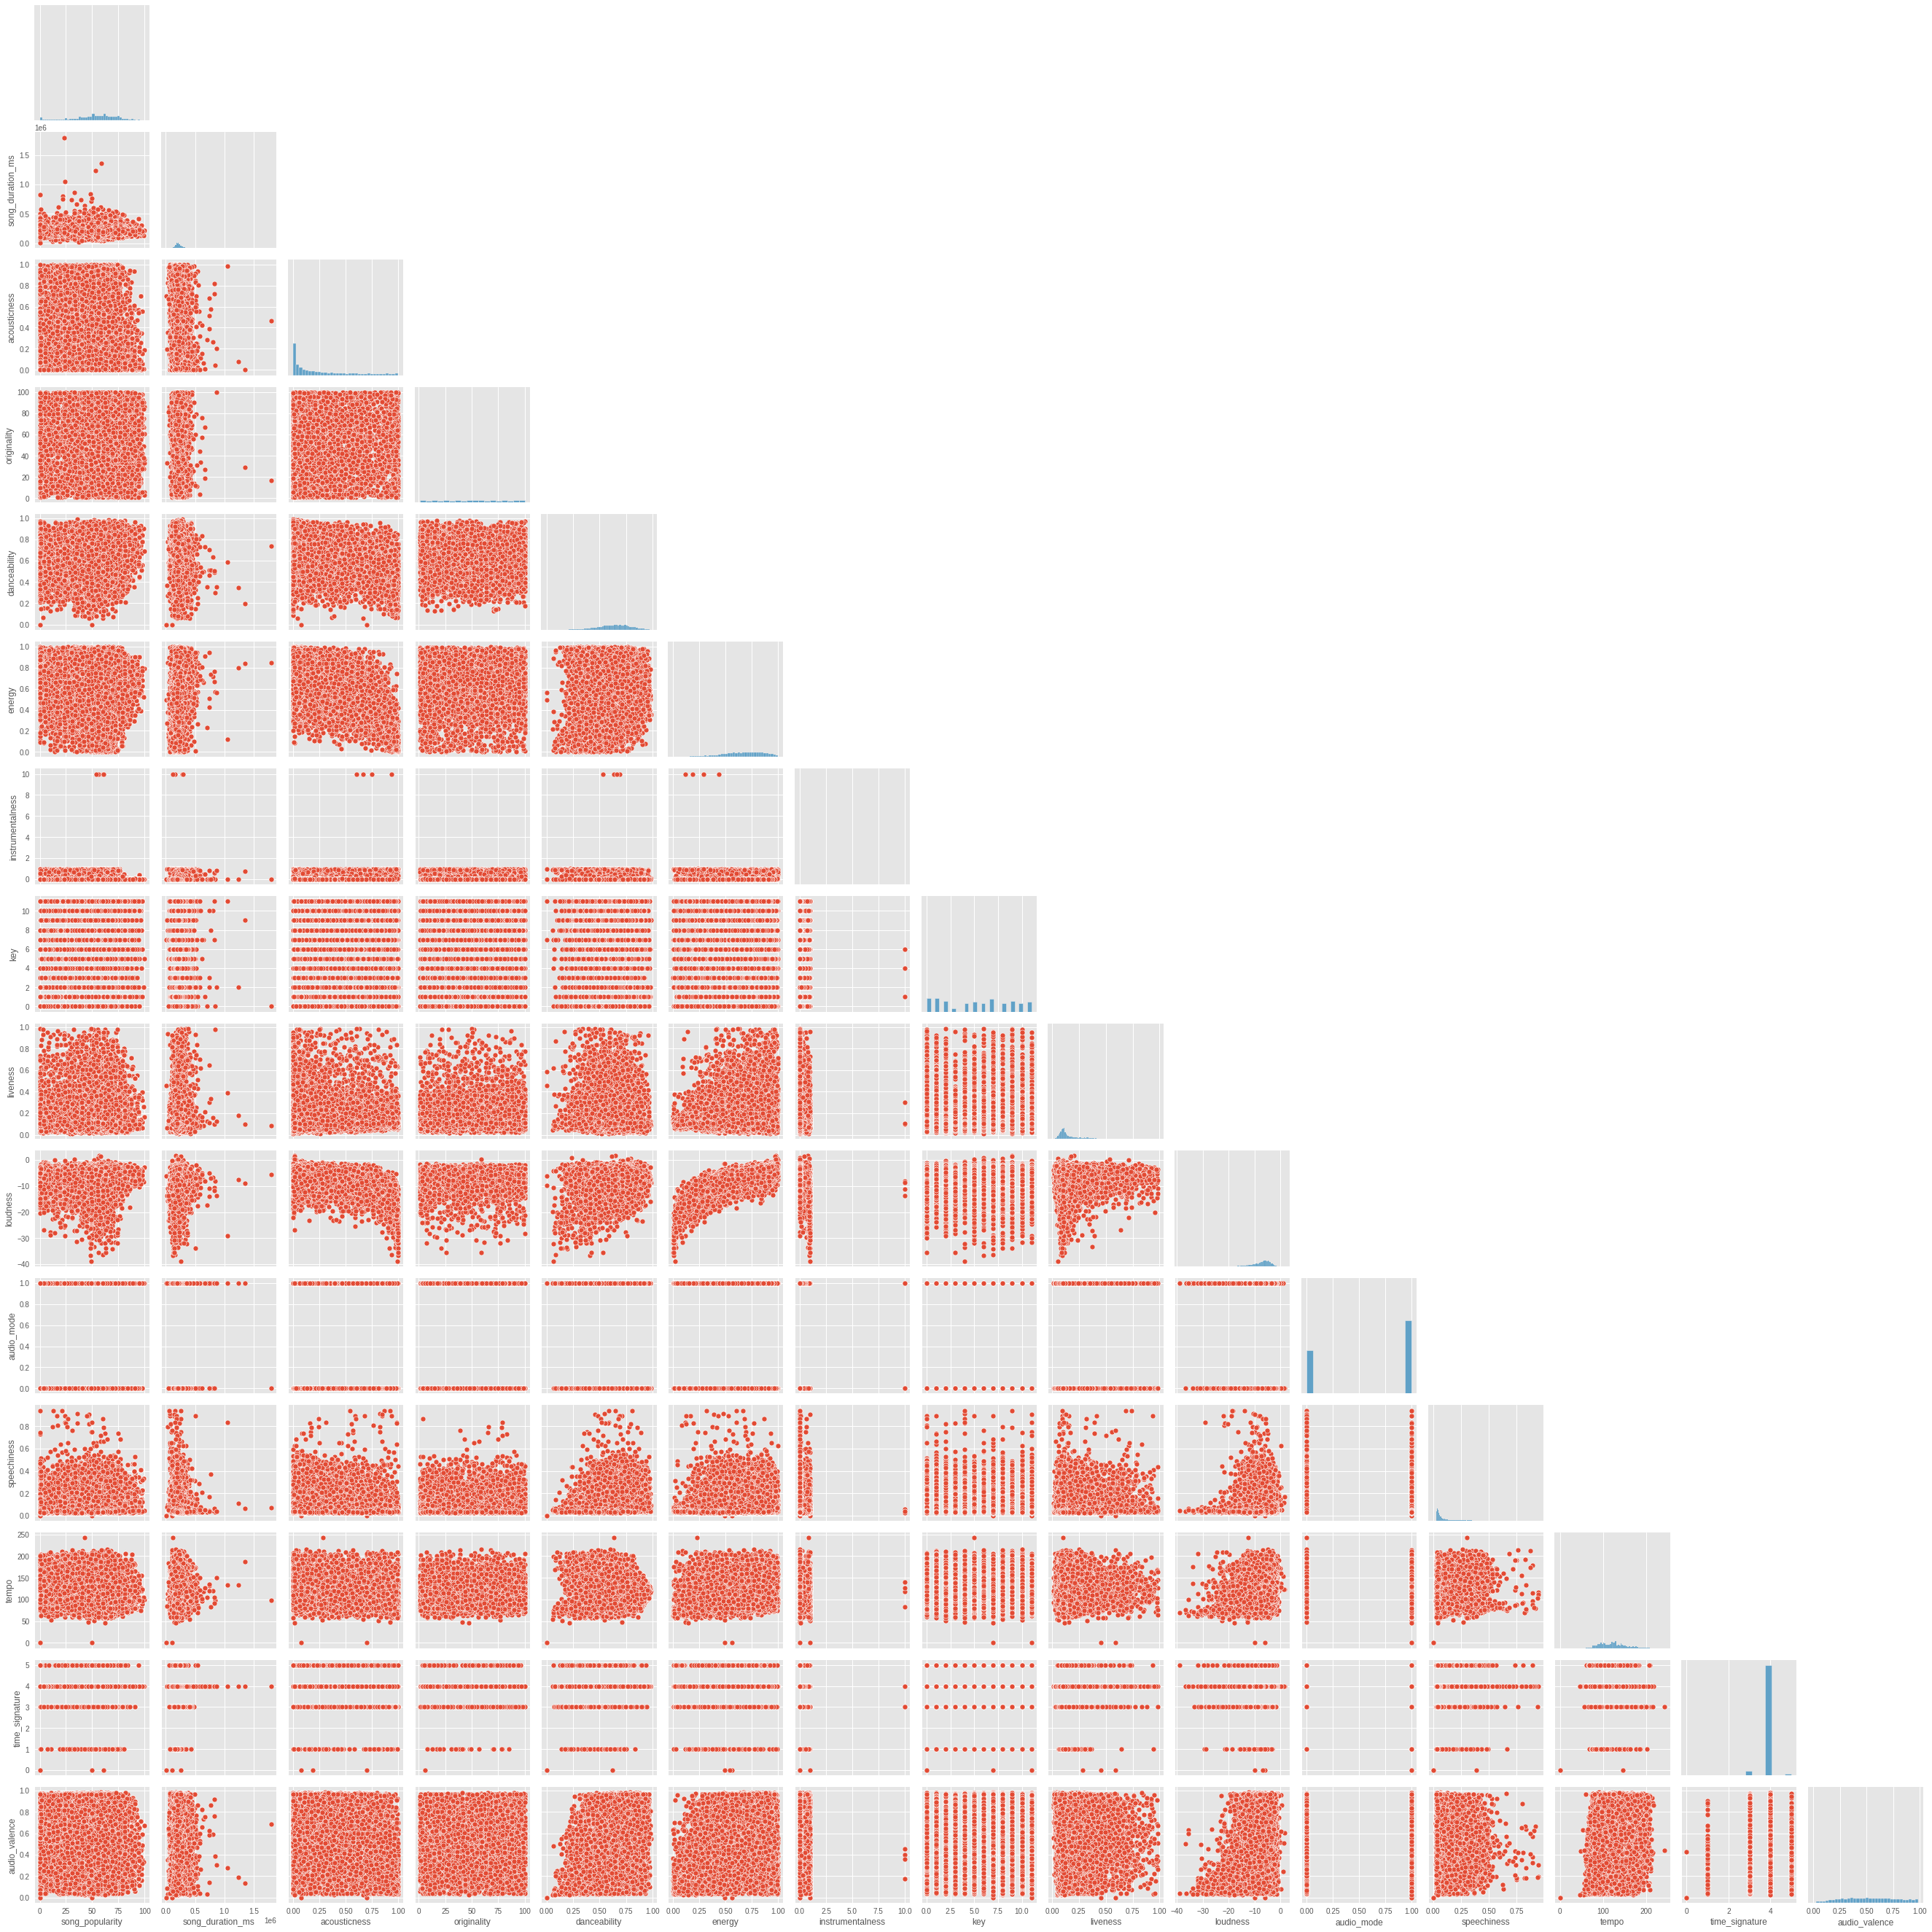

In [ ]:
sns.pairplot(data = ds, corner= True )

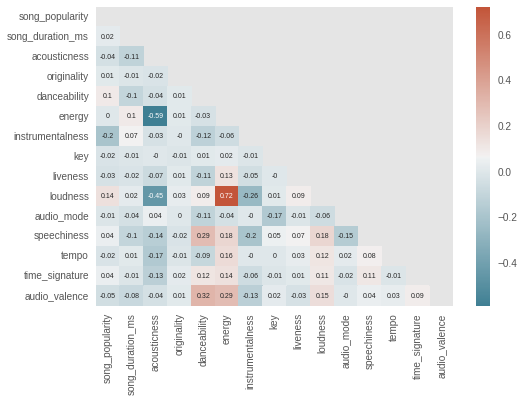

In [ ]:

mask = np.triu(np.ones_like(round(ds.corr(),2)))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(data = round(ds.corr(method = 'spearman'),2), mask = mask ,cmap = cmap, annot=True, annot_kws={"size": 7})

## Comments to the correlation matrix and consideration before data manipulation

 * No variable seems to be stricly correlated to the popularity, which will make the modelling potentially hard, if no new feature is adopted --> hence feature engineering will be essential as proven in other cases: <br>
 * Ref. articble: https://towardsdatascience.com/predicting-popularity-on-spotify-when-data-needs-culture-more-than-culture-needs-data-2ed3661f75f1
 * There is no multicollinearity among variables, if not for a strong relation between loudness and energy
 * Popularity is not normally distributed, and there is a spike in case of "0" popularity (new releases, as stated in the beggining of this report). As no binning option is possible in this task, it will be necessary to keep the variable as continuous. 
 * Some variables will be transformed for better manipulation and we decided to drop originality, as 70% of the column is empty and there is no clear information gain in keeping it
 * Popularity = 0 seems to be out of scope of prediction, because it should be the calculation not provided by Spotify and seems out of business scope to predict a song with 0 popularity (new release).
 

# <font color = '#FF5733'>3 - Data preparation</font> <a class = "anchor" id = preparation></a>

[back to content](#contents)

* Drop variable originality because of the amount of missing values (70%)<br>
* Drop time_signature, key and audio_mode because of reduncancy and low variability<br>
* Modify variable key in number and replace it as new chords with major <br>
* Create some new features to make the songs being more distinctive between popular and less popular <br>
* remove "wrong values" like tempo = 0 <br>
* Attempt to compensate song_popularity for songs with song_popularity=0 <br> 
* Narrow the dataset by removing outliers
* Reevaluate correlations to check changes


In [ ]:
key_conversion = {0 : 'C' , 
                    1 : 'C-#' ,
                    2 : 'D',
                    3 : 'D-#',
                    4 : 'E' , 
                    5 : 'F' , 
                    6 : 'F-#' , 
                    7 : 'G' , 
                    8 : 'G-#',
                    9 : 'A' , 
                    10: 'A-#', 
                    11: 'B'}

major_minor = {1: 'major',
                0: 'minor'}

# mapping of moods based on the relevant key of the song
## chord progression are essential in transferring an emotion. Different emotions combined with the right tuning of songs
## features can help to trigger a "popular song" given its own mood. some Pop songs are sad, some happy, some energic. 
## few of them are pious or sever, unless we talk about reinassance gospel
## https://ledgernote.com/blog/interesting/musical-key-characteristics-emotions/ 

moods = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mood_ml_project.csv', delimiter = '\t')

In [ ]:
moods.head()

full_mode   mood
0    C-major    joy
1    C-minor    sad
2  C-#-major    joy
3  C-#-minor    sad
4    D-major  harsh

In [ ]:
def data_cleaning(ds):
    ## dropping originality because of 70% of nulls & time sign because of reduncancy and low variability
    ds.drop(axis = 1, columns = ['originality', 'time_signature'], inplace= True)
    ds.drop_duplicates(inplace= True)
    
    ds['mode'] = ds['audio_mode'].apply(lambda x: major_minor[x])
    ds['chord'] = ds['key'].apply(lambda x : key_conversion[x])
    #ds['new_chords'] = X['chord'].astype('str') + '-' + X['mode'].astype(str)
    ds['song_duration'] = ds['song_duration_ms'].apply(lambda x: round(x/60000, 2))
    ds['instrumentalness'] = np.where(ds['instrumentalness'] >= ds['instrumentalness'].quantile(0.75), ds['instrumentalness'].quantile(0.75),ds['instrumentalness'])
    ds.drop(axis = 1, columns = ['audio_mode', 'key', 'song_duration_ms'], inplace = True)

    
    return ds

In [ ]:
ds1 = ds.copy(deep = True)
X = data_cleaning(ds1)

In [ ]:
def RemoveOutliers (df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

numerical=X.select_dtypes(include=[np.number]).columns.tolist()
X = RemoveOutliers(X, colList=numerical , lowPercentile=0.002, highPercentile=0.998, verbose=True)
# we aim to remove around 2-4% of dataset at maximum, in order to save data 
# and don't lose the highest and lowest points of popularity 

       song_popularity  acousticness  danceability    energy  \
0.002              0.0      0.000006      0.129562  0.007812   
0.998             94.0      0.995000      0.960292  0.993000   

       instrumentalness  liveness   loudness  speechiness       tempo  \
0.002           0.00000  0.026256 -29.693314     0.024300   61.629386   
0.998           0.00517  0.925292  -1.326686     0.666482  206.105732   

       audio_valence  song_duration  
0.002       0.034885        1.14000  
0.998       0.974000        8.94292  


In [ ]:
print(str(X.shape) + ' vs ' + str(ds1.shape) +  '\n' + ' have been removed ' + 
      str(ds1.shape[0] - X.shape[0]) + ' rows as outliers' + '\n' + 
      'equivalent to ' + str(round((ds1.shape[0] - X.shape[0])/ ds1.shape[0],2)))

(14451, 14) vs (14928, 14)
 have been removed 477 rows as outliers
equivalent to 0.03


In [ ]:
X['new_chords'] = X['chord'].astype(str) + '-' + X['mode']
X = X.merge(moods, how = 'left', left_on = 'new_chords', right_on='full_mode')
X.head()

song_name  song_popularity  acousticness  danceability  \
0  Boulevard of Broken Dreams               73      0.005520         0.496   
1                  In The End               66      0.010300         0.542   
2           Seven Nation Army               76      0.008170         0.737   
3                  By The Way               74      0.026400         0.451   
4           How You Remind Me               56      0.000954         0.447   

   energy  instrumentalness  liveness  loudness  speechiness    tempo  \
0   0.682          0.000029    0.0589    -4.095       0.0294  167.060   
1   0.853          0.000000    0.1080    -6.407       0.0498  105.256   
2   0.463          0.005170    0.2550    -7.828       0.0792  123.881   
3   0.970          0.003550    0.1020    -4.938       0.1070  122.444   
4   0.766          0.000000    0.1130    -5.065       0.0313  172.011   

   audio_valence   mode chord  song_duration new_chords  full_mode    mood  
0          0.474  major   G-#           4.37  G-#-major  G-#-major  strong  
1          0.370  minor   D-#           3.62  D-#-minor  D-#-minor  boring  
2          0.324  major     C           3.86    C-major    C-major     joy  
3          0.198  major     C           3.62    C-major    C-major     joy  
4          0.574  major   A-#           3.73  A-#-major  A-#-major   harsh

In [ ]:
X.columns

Index(['song_name', 'song_popularity', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'audio_valence', 'mode', 'chord', 'song_duration',
       'new_chords', 'full_mode', 'mood'],
      dtype='object')

In [ ]:
## imputer attempt to compensate for the 0 popularity songs 
## instead of dropping to dataset, as they have similar features values to other songs
## we attempt an imputation for those songs
from sklearn.impute import KNNImputer

X['song_popularity'] = np.where(X['song_popularity'] == 0 , np.nan,X['song_popularity'] ) 
imp_pop = KNNImputer(n_neighbors=5)

X['song_popularity'] = imp_pop.fit_transform(X[['song_popularity', 'danceability',
                                                'energy', 'tempo']])[:,0]
X['song_popularity'] = X['song_popularity'].apply(lambda x: round(x, 0))                                                 



'minimum popularity after imputation = 1.0'

'minimum popularity before imputation = 0'

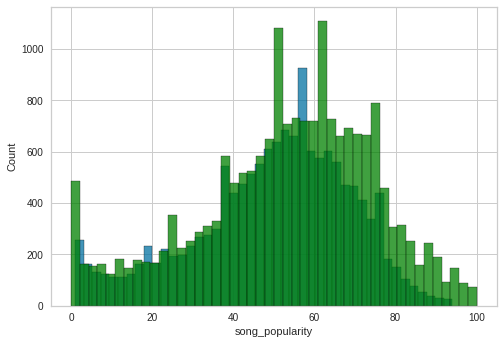

In [ ]:
display(sns.histplot(X.song_popularity), 
        sns.histplot(ds.song_popularity, color= 'green'), 
        'minimum popularity after imputation = ' + str(min(X.song_popularity)),
        'minimum popularity before imputation = ' + str(min(ds.song_popularity)))

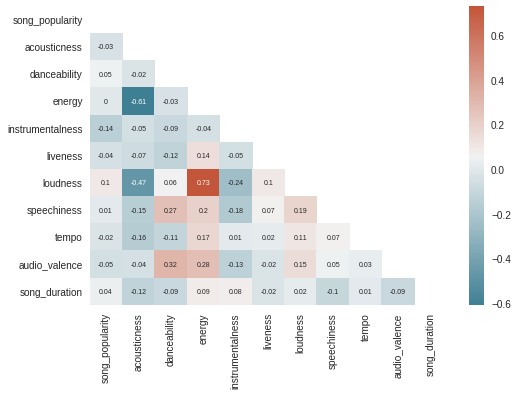

In [ ]:
## check on correlation to see if the imputer skewed some relation
mask = np.triu(np.ones_like(round(X.corr(),2)))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(data = round(X.corr(method = 'spearman'),2), mask = mask ,cmap = cmap, annot=True, annot_kws={"size": 7})

In [ ]:
## iteration with mood songs instead of chords
X.drop(columns = ['mode', 'chord', 'new_chords', 'full_mode'], inplace = True )

In [ ]:
X.describe(include = 'all').T

count unique     top  freq        mean        std  \
song_name           14451  12646  Heaven     8         NaN        NaN   
song_popularity   14451.0    NaN     NaN   NaN   49.523216  19.424326   
acousticness      14451.0    NaN     NaN   NaN    0.267015   0.294205   
danceability      14451.0    NaN     NaN   NaN    0.627468   0.153801   
energy            14451.0    NaN     NaN   NaN    0.642028   0.216802   
instrumentalness  14451.0    NaN     NaN   NaN    0.001466   0.002201   
liveness          14451.0    NaN     NaN   NaN    0.178996   0.140528   
loudness          14451.0    NaN     NaN   NaN   -7.568616   3.703156   
speechiness       14451.0    NaN     NaN   NaN    0.097879   0.098311   
tempo             14451.0    NaN     NaN   NaN  121.224803  28.516324   
audio_valence     14451.0    NaN     NaN   NaN    0.529619   0.245526   
song_duration     14451.0    NaN     NaN   NaN      3.6387   0.925256   
mood                14451      5     joy  4802         NaN        NaN   

                       min      25%       50%       75%      max  
song_name              NaN      NaN       NaN       NaN      NaN  
song_popularity        1.0     38.0      52.0      64.0     94.0  
acousticness      0.000006   0.0238     0.138     0.452    0.995  
danceability          0.13    0.528     0.638     0.741     0.96  
energy             0.00844    0.498     0.673     0.817    0.993  
instrumentalness       0.0      0.0  0.000019   0.00419  0.00517  
liveness            0.0263   0.0931     0.122     0.223    0.925  
loudness           -29.673   -9.321    -6.726    -4.994   -1.328  
speechiness         0.0243   0.0371    0.0539     0.112    0.664  
tempo               61.638  98.8365   120.026  139.9405  206.085  
audio_valence       0.0349    0.336     0.529     0.729    0.974  
song_duration         1.14     3.07      3.53      4.07     8.94  
mood                   NaN      NaN       NaN       NaN      NaN

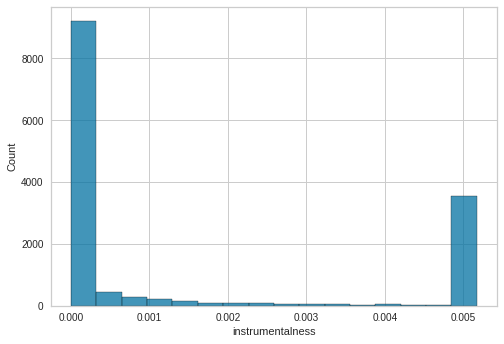

In [ ]:
sns.histplot(data = X, x = 'instrumentalness')

# <font color = '#FF5733'>3.1 - Feature Engineering</font> <a class = "anchor" id = engineering></a>

[back to content](#contents)

* Create a custom variable that considers the main features for the popularity, as a trial to get a higher correlation index that allows us to execute a successful regression model later<br>
* Fitting song_popularity into a normal distribution


In [ ]:
## in addition to the existing feature we create a custom feature which considers 
## the main features for each song
## appeal of a song can be related to energy and danceability and enhanced by loudness and tempo

import math
X['appeal'] = (X['energy']*100 + X['danceability']*100 + (1+X['loudness']/100) * (X['tempo']))/ 400
print(str(X['appeal'].min()) + '  ' + str(X['appeal'].max()))
X['appeal'].describe().T


0.18220000312499998  0.8941833159999998


count    14451.000000
mean         0.597796
std          0.102883
min          0.182200
25%          0.536881
50%          0.609938
75%          0.671612
max          0.894183
Name: appeal, dtype: float64

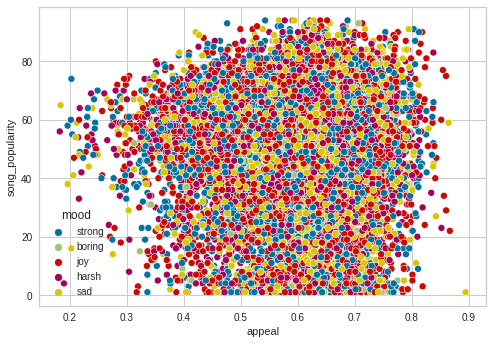

In [ ]:
sns.scatterplot(data = X, x = 'appeal', y = 'song_popularity', hue = 'mood')

In [ ]:
from scipy.stats import pearsonr , spearmanr

pea_corr, _ = pearsonr(np.array(X['song_popularity']), np.array(X['appeal']))
spr_corr, _ = spearmanr(np.array(X['song_popularity']), np.array(X['appeal']))
print('Pearson correlation: %.3f' % pea_corr)
print('Spearmans correlation: %.3f' % spr_corr)

## unfortunately 0 correlation with song_popularity, but as we will run feature selections alg. and DT
## we can check anyway the importance and drop it


Pearson correlation: 0.011
Spearmans correlation: 0.015


In [ ]:
## one hot enconding of the mood variable

ce_one_hot = ce.OneHotEncoder(cols = 'mood',use_cat_names=True)
X = ce_one_hot.fit_transform(X)


In [ ]:
## fitting the song popularity to a normal distribution to better handle the models outcome
## and analyse the residuals

quantile = preprocessing.QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=28)
X['song_popularity'] = quantile.fit_transform(X[['song_popularity']])

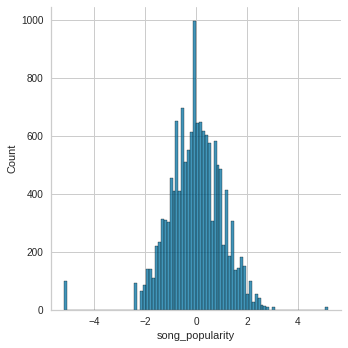

In [ ]:
sns.displot(data = X, x = 'song_popularity')

In [ ]:
## limit the dataset to the values of popularity between [-3,3] std. dev

X = X.loc[(X.song_popularity >= -3) & (X.song_popularity <= 3)]
X.head()

song_name  song_popularity  acousticness  danceability  \
0  Boulevard of Broken Dreams         1.335178      0.005520         0.496   
1                  In The End         0.834427      0.010300         0.542   
2           Seven Nation Army         1.549706      0.008170         0.737   
3                  By The Way         1.399657      0.026400         0.451   
4           How You Remind Me         0.229884      0.000954         0.447   

   energy  instrumentalness  liveness  loudness  speechiness    tempo  \
0   0.682          0.000029    0.0589    -4.095       0.0294  167.060   
1   0.853          0.000000    0.1080    -6.407       0.0498  105.256   
2   0.463          0.005170    0.2550    -7.828       0.0792  123.881   
3   0.970          0.003550    0.1020    -4.938       0.1070  122.444   
4   0.766          0.000000    0.1130    -5.065       0.0313  172.011   

   audio_valence  song_duration  mood_strong  mood_boring  mood_joy  \
0          0.474           4.37            1            0         0   
1          0.370           3.62            0            1         0   
2          0.324           3.86            0            0         1   
3          0.198           3.62            0            0         1   
4          0.574           3.73            0            0         0   

   mood_harsh  mood_sad    appeal  
0           0         0  0.695047  
1           0         0  0.595031  
2           0         0  0.585459  
3           0         0  0.646244  
4           1         0  0.711497

# <font color = '#FF5733'>4 - Modelling</font> <a class = "anchor" id = import></a>


[back to content](#content)


In [ ]:
## add custom function for min max of Pandas series for y_target

def MinMaxSeries(serie):
    low = serie.min()
    high = serie.max()
    serie = serie.apply(lambda x: (x - low)/(high - low))
    return serie

# <font color = '#FF5733'>4.1 - Linear Model</font> <a class = "anchor" id = LR></a>

[back to content](#contents)


In [ ]:
#create a new copy of the dataset
LR=X.copy(deep=True)

#create target variable
y_LR= X['song_popularity']

#erase target variable & song name from train, since song name won't help us predicting the model
LR.drop(columns=["song_popularity", 'song_name'], inplace = True )

In [ ]:
#Normalize variables in order to run a LR
LR = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(LR.values), columns=LR.columns,index=LR.index)

y_LR = MinMaxSeries(y_LR)

In [ ]:
# Split the dataset intro train and test
LR_train, LR_test, y_LR_train, y_LR_test = train_test_split(LR, y_LR, train_size = 0.75, test_size = 0.25, random_state = 2021)

In [ ]:
#Initialize model
lr_regr = linear_model.LinearRegression()

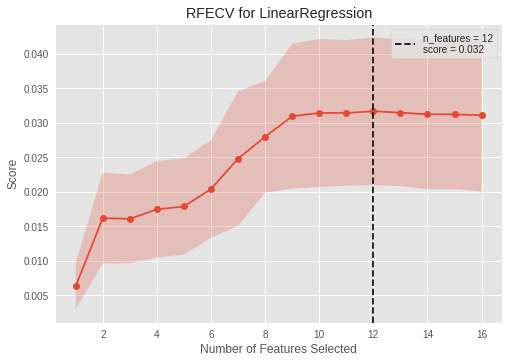

In [ ]:
# Apply RFECV to select features
# We decide to use 10-fold cross-validations and use the R2 as our score
# As seen in the graph, our optimum would be having 10 features
vis = RFECV(lr_regr, cv=10, scoring='r2')
vis.fit(LR_train, y_LR_train)
vis.show()

In [ ]:
## check features taken into account
LR_train.columns[vis.support_]

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence',
       'song_duration', 'mood_boring', 'appeal'],
      dtype='object')

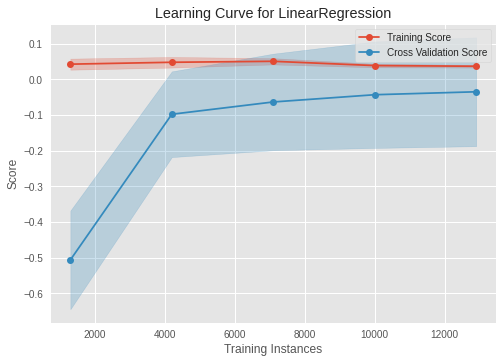

In [ ]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(LR, y_LR)
visualizer.show()   

In [ ]:
# Create and train the model
lr_regr.fit(LR_train, y_LR_train)

LinearRegression()

In [ ]:
# Print the Intercept
print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
# Here we can seee that most relevant variables are: loudness, appeal and energy
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(LR.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 0.4022737848745081 



Feature Coefficient  AbsCoefficient
15            appeal    0.232691        0.232691
2             energy   -0.188791        0.188791
5           loudness    0.173593        0.173593
7              tempo   -0.118323        0.118323
8      audio_valence   -0.045578        0.045578
3   instrumentalness   -0.045129        0.045129
4           liveness   -0.043641        0.043641
9      song_duration    0.035922        0.035922
0       acousticness   -0.034700        0.034700
1       danceability   -0.019838        0.019838
11       mood_boring   -0.018036        0.018036
6        speechiness   -0.017004        0.017004
14          mood_sad    0.007648        0.007648
10       mood_strong    0.005002        0.005002
12          mood_joy    0.004588        0.004588
13        mood_harsh    0.000798        0.000798

# <font color = '#FF5733'>5.1 - Evaluation Linear Regression</font> <a class = "anchor" id = EV_LR></a>

[back to content](#contents)


In [ ]:
# predict y for X_train and X_test
y_LR_pred_train = lr_regr.predict(LR_train) 
y_LR_pred_test = lr_regr.predict(LR_test) 

In [ ]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [ ]:
# Show performance results
# It's possible to observe that R2 for train and test remain small, therefore the variability of the indep. variable can't be explained by the variables in this model
# MAPE value, which explains forecast accuracy remains very high
# LR Model is not reliable
LR_resultsDF = performanceMetricsDF(metrics, y_LR_train, y_LR_pred_train, y_LR_test, y_LR_pred_test)
LR_resultsDF

Measure         Train          Test
0        MAE  1.491225e-01  1.508133e-01
1       RMSE  1.848849e-01  1.870737e-01
2        R^2  3.540506e-02  3.647402e-02
3   MAPE (%)  1.320838e+13  1.351038e+13
4  MAX Error  5.264694e-01  5.436432e-01

In [ ]:
# Visualize predictions vs target values 
LRtemp = y_LR_test.to_frame()
LRtemp['Prediction'] = y_LR_pred_test
LRtemp['Residual'] = y_LR_test - LRtemp.Prediction
LRtemp

song_popularity  Prediction  Residual
8288          0.180033    0.441468 -0.261435
171           0.755365    0.471381  0.283984
12129         0.335128    0.423196 -0.088068
11858         0.198513    0.426466 -0.227952
8672          0.875606    0.462315  0.413291
...                ...         ...       ...
7307          0.667018    0.435743  0.231275
12394         0.453064    0.473197 -0.020133
882           0.641779    0.490293  0.151486
8701          0.653978    0.431867  0.222111
9896          0.696463    0.474819  0.221644

[3584 rows x 3 columns]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



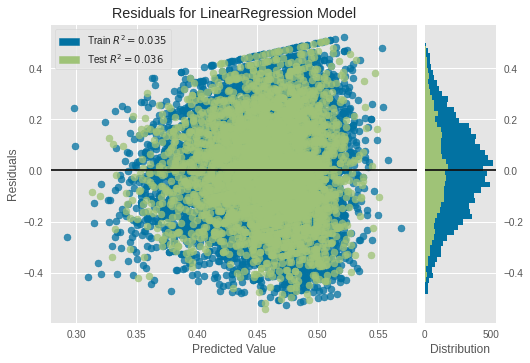

In [ ]:
# Visualize the residuals
LR_residuals_vis = ResidualsPlot(lr_regr)
LR_residuals_vis.fit(LR_train, y_LR_train)  # Fit the training data to the visualizer
LR_residuals_vis.score(LR_test, y_LR_test)  # Evaluate the model on the test data
LR_residuals_vis.show() 

**Comments on LR ** <br>

The residuals don't follow an exact normal distribution, more distributed to negative predictions, so general underestimation of values. In general the residuals are high and the explicative power of the model is extremely poor.

# <font color = '#FF5733'>4.2 - Decision Tree</font> <a class = "anchor" id = DT></a>

[back to content](#contents)


In [ ]:
#create a new copy of the dataset
DT=X.copy(deep=True)

#create target variable
y_DT= X['song_popularity']

#erase target variable & song name from train, since song name won't help us predicting the model
DT.drop(columns=["song_popularity", 'song_name'], inplace = True )

In [ ]:
# Split the dataset intro train and test
DT_train, DT_test, y_DT_train, y_DT_test = train_test_split(DT, y_DT, train_size = 0.7, test_size = 0.3, random_state = 2021)

In [ ]:
#Initialize model
tree_regr = tree.DecisionTreeRegressor(random_state=1, 
                                       criterion = 'friedman_mse',
                                       max_depth=4, 
                                       min_samples_leaf=20)

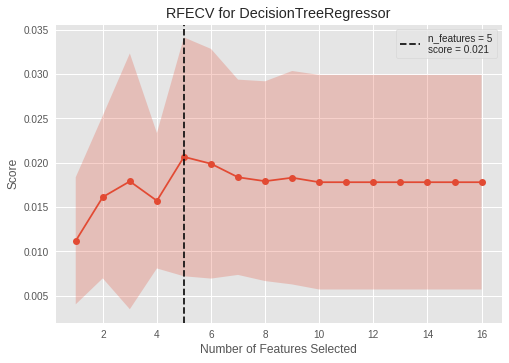

In [ ]:

# Apply RFECV to select features
# Same procedure as the model before, we can observe that for this case only 5 features are selected as the most relevant. Some of them were also pointed as with high coefficients in the LR model.
vis = RFECV(tree_regr, cv=10, scoring='r2')
vis.fit(DT_train, y_DT_train)
vis.show()

In [ ]:
# Most relevant Features Selected: 'acousticness', 'danceability', 'instrumentalness', 'loudness', 'audio_valence'
# This type of model is more sensitive in terms of feature selection.
# So, this information can be used as an "input" for the next models in order to understand which extra variables can we drop to get better results
DT.columns[vis.support_]

Index(['acousticness', 'danceability', 'instrumentalness', 'loudness',
       'audio_valence'],
      dtype='object')

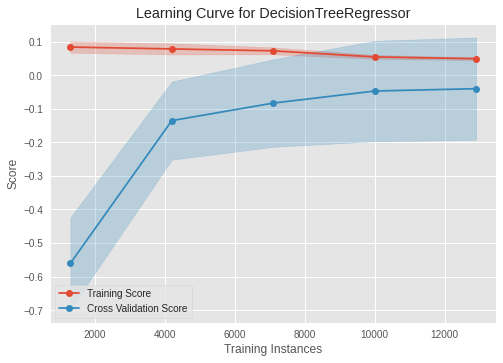

In [ ]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator= tree_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(DT, y_DT)
visualizer.show()   

In [ ]:
# Create and train the model
tree_regr.fit(DT_train, y_DT_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                      min_samples_leaf=20, random_state=1)

In [ ]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in tree_regr.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in tree_regr.feature_importances_]
data_tuples = list(zip(DT.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

## Mood, appeal and speechiness are irrelevant for the prediction and discarted. 
## Unfortunately due to noise there is no good fit in the data

Feature  Coefficient  AbsCoefficient
3   instrumentalness     0.358621        0.358621
5           loudness     0.190904        0.190904
8      audio_valence     0.157019        0.157019
1       danceability     0.098657        0.098657
0       acousticness     0.089218        0.089218
9      song_duration     0.079730        0.079730
2             energy     0.025852        0.025852
4           liveness     0.000000        0.000000
6        speechiness     0.000000        0.000000
7              tempo     0.000000        0.000000
10       mood_strong     0.000000        0.000000
11       mood_boring     0.000000        0.000000
12          mood_joy     0.000000        0.000000
13        mood_harsh     0.000000        0.000000
14          mood_sad     0.000000        0.000000
15            appeal     0.000000        0.000000

# <font color = '#FF5733'>5.2 - Evaluation Decision Tree</font> <a class = "anchor" id = EV_DT></a>

[back to content](#contents)

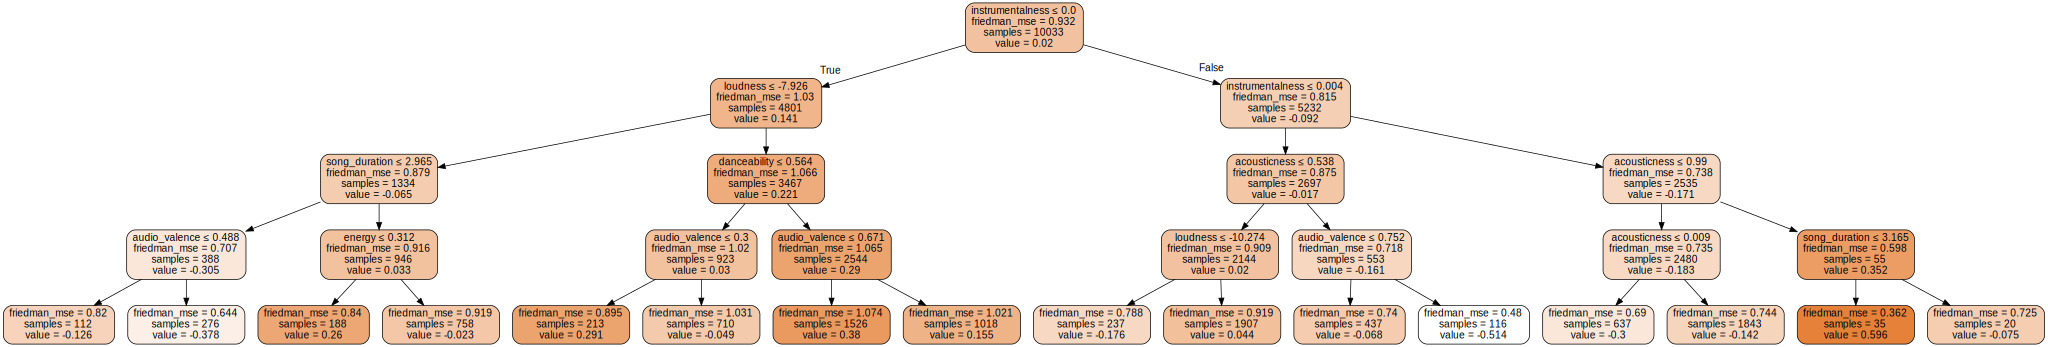

In [ ]:
# Graph DT
import graphviz
dot_data = tree.export_graphviz(tree_regr, out_file=None, 
                      feature_names=list(DT_train.columns),  
                      class_names='Returns',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 




In [ ]:
# predict y for X_train and X_test
y_DT_pred_train = tree_regr.predict(DT_train) 
y_DT_pred_test = tree_regr.predict(DT_test) 

In [ ]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [ ]:
# Show performance results
DT_resultsDF = performanceMetricsDF(metrics, y_DT_train, y_DT_pred_train, y_DT_test, y_DT_pred_test)
DT_resultsDF

#Here we can see that even though R2 using this method is higher when compared to LR, it is still smaller, but it improves.

Measure         Train          Test
0        MAE  7.565963e-01  7.690504e-01
1       RMSE  9.408053e-01  9.559281e-01
2        R^2  4.991143e-02  3.815733e-02
3   MAPE (%)  1.747066e+13  1.866615e+13
4  MAX Error  2.812757e+00  2.946137e+00

In [ ]:
#Since the variables: liveness, speechiness and tempo don't explain the target variable (coeff=0) we will remove them on the next models

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



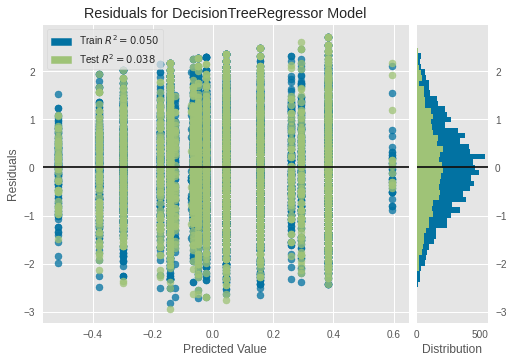

In [ ]:
# Visualize the residuals
DT_residuals_vis = ResidualsPlot(tree_regr)
DT_residuals_vis.fit(DT_train, y_DT_train)  # Fit the training data to the visualizer
DT_residuals_vis.score(DT_test, y_DT_test)  # Evaluate the model on the test data
DT_residuals_vis.show() 

**Comments on DT **

In general the model slightly overfits compared to the train, and as we can see from the predicted value, the major problem of the model is that it cannot capture the whole spectrum of the popularity index that appears in the dataset. All the songs have too similar values and there is poor variability which drived to different prediction. <br>
Overall the residuals follow a skewed gaussian curve, with a very poor overall R2 for the model.

# <font color = '#FF5733'>4.3 - Neural network with random search</font> <a class = "anchor" id = MLP></a>

[back to content](#contents)

In [ ]:
# Box Plot exploration

@interact

def plot_num(column = numerical):
    
    plt.figure(figsize=(8,6))
    return sns.boxplot(X[column])

interactive(children=(Dropdown(description='column', options=('song_popularity', 'acousticness', 'danceability…

In [ ]:
X.columns

Index(['song_name', 'song_popularity', 'acousticness', 'danceability',
       'energy', 'liveness', 'loudness', 'speechiness', 'tempo',
       'audio_valence', 'song_duration', 'mood_strong', 'mood_boring',
       'mood_joy', 'mood_harsh', 'mood_sad', 'appeal'],
      dtype='object')

In [ ]:
#create a new copy of the dataset
MLP=X.copy(deep=True)

#create target variable
y_MLP=X['song_popularity']

#e for the neural network we follow the features selected by the decision tree, dropping the ones too sparse and the correlated ones
MLP.drop(columns=["song_popularity", 'song_name', 'speechiness', 'energy', 'liveness', 'mood_strong',	
                  'mood_boring', 	'mood_joy', 'mood_harsh', 'mood_sad'], inplace = True )



In [ ]:
#Normalize variables in order to run Random Search
MLP = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(MLP.values), columns=MLP.columns,index=MLP.index)
y_MLP = MinMaxSeries(y_MLP)

In [ ]:
# Split the dataset intro train and test
MLP_train, MLP_test, y_MLP_train, y_MLP_test = train_test_split(MLP, y_MLP, train_size = 0.75, test_size = 0.25, random_state = 2021)

In [ ]:
# Execute Randomized Search to hyper tune parameters
random_param = {'hidden_layer_sizes': [3,4,5,6,7,8],
          'activation': ['tanh', 'relu'],
          'solver':['lbfgs', 'adam'],
          'alpha':[0.0001, 0.002, 0.05],
          'batch_size':['auto'],
          'learning_rate':['constant'],
          'learning_rate_init':[0.001, 0.002],
          'max_iter':[100,300,500,700,900],
          'random_state':[123]}
reg = MLPRegressor()
# We have tried with different numbers of iterations from 20 to 60
# We keep 40, since we have seen that the results after that number don't represent considerable improvements on the R2 of the model
rand = RandomizedSearchCV(reg, param_distributions=random_param, cv=5, n_iter = 40)
rand.fit(MLP_train, y_MLP_train)
print("Random search best parameters: {}".format(rand.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Random search best parameters: {'solver': 'lbfgs', 'random_state': 123, 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': 4, 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
# Create the model
## working best parameters
"""'solver': 'lbfgs', 
    'random_state': 123,
     'max_iter': 300, 
     'learning_rate_init': 0.001,
      'learning_rate': 'constant', 
      'hidden_layer_sizes': 4, 
      'batch_size': 'auto', 
      'alpha': 0.0001,
       'activation': 'tanh'} """
MLPestimator = MLPRegressor(**rand.best_params_)

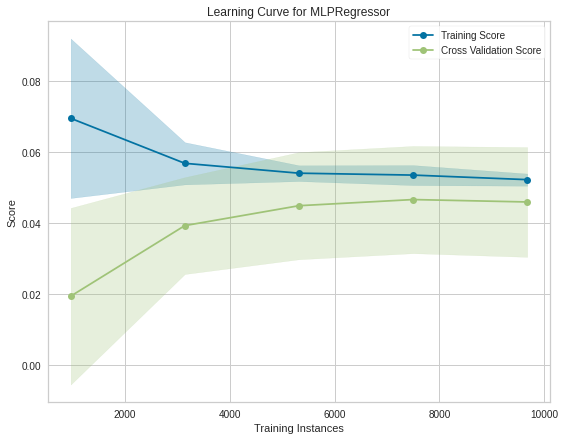

In [ ]:
# Plot the learning curve
fig, ax = plt.subplots(figsize=(9, 7))
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=MLPestimator, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(MLP_train, y_MLP_train)
visualizer.show(ax=ax)

In [ ]:
# Create and train the model
MLPestimator.fit(MLP_train, y_MLP_train)

MLPRegressor(activation='tanh', hidden_layer_sizes=4, max_iter=300,
             random_state=123, solver='lbfgs')

# <font color = '#FF5733'>5.3 - Evaluation of Neural network with random search</font> <a class = "anchor" id = EV_MLP></a>

[back to content](#contents)

In [ ]:
# predict y for X_train and X_test
y_MLP_pred_train = MLPestimator.predict(MLP_train) 
y_MLP_pred_test = MLPestimator.predict(MLP_test) 

In [ ]:
# Show performance results
MLP_resultsDF = performanceMetricsDF(metrics, y_MLP_train, y_MLP_pred_train, y_MLP_test, y_MLP_pred_test)
MLP_resultsDF['Train'] = MLP_resultsDF['Train'].apply(lambda x: round(x,3))
MLP_resultsDF['Test'] = MLP_resultsDF['Test'].apply(lambda x: round(x,3)) 

MLP_resultsDF

#R2 train and test are similar, therefore the model is not overfitting.
#R2 improves compared to the models presented before

Measure         Train          Test
0        MAE  1.470000e-01  1.500000e-01
1       RMSE  1.830000e-01  1.860000e-01
2        R^2  5.200000e-02  4.600000e-02
3   MAPE (%)  1.314393e+13  1.338928e+13
4  MAX Error  5.450000e-01  5.540000e-01

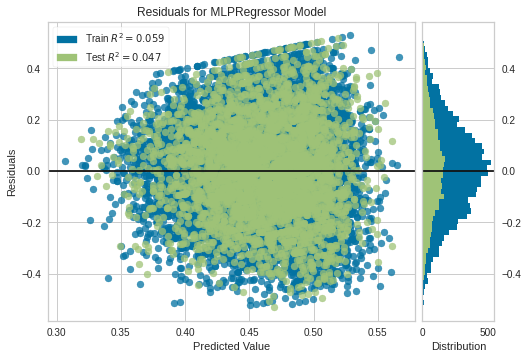

In [ ]:
# Visualize the residuals
MLP_residuals_vis = ResidualsPlot(reg)
MLP_residuals_vis.fit(MLP_train, y_MLP_train)  # Fit the training data to the visualizer
MLP_residuals_vis.score(MLP_test, y_MLP_test)  # Evaluate the model on the test data
MLP_residuals_vis.show() 

**Comments on MLP with Random Search**

In general the model doesn't overfit when compared to the train, and as we can see from the predicted value. <br>
The main problem is that so far none of these models are able to capture the variability of the song_popularity variable. <br>
R2 is still very poor, but improves when compared to the previous models used.

# <font color = '#FF5733'>4.4 - Random Forest </font> <a class = "anchor" id = RF></a>
<p>  Random forest execution with Random hypertuning search method for performance 
[back to content](#contents)

In [ ]:
X.columns

Index(['song_name', 'song_popularity', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'audio_valence', 'song_duration', 'mood_strong', 'mood_boring',
       'mood_joy', 'mood_harsh', 'mood_sad', 'appeal'],
      dtype='object')

In [ ]:
#create a new copy of the dataset
RF=X.copy(deep=True)

#create target variable
y_RF= X['song_popularity']

#erase target variable & song name from train
RF.drop(columns=["song_popularity", 'song_name', 'acousticness', 'mood_sad', 'liveness', 'mood_strong', 'mood_boring',
       'mood_joy', 'mood_harsh', 'mood_sad', 'appeal', 'energy', 'speechiness'], inplace = True )

In [ ]:
# Split the dataset intro train and test
RF_train, RF_test, y_RF_train, y_RF_test = train_test_split(RF, y_RF, train_size = 0.7, test_size = 0.3, random_state = 2021)

In [ ]:
#Initialize model
RF_regr = RandomForestRegressor(random_state =  123,
                                n_estimators =  100, 
                                min_samples_split =  4,
                                min_samples_leaf = 1, 
                                min_impurity_decrease =  0.01,
                                max_leaf_nodes =  25, 
                                max_depth =  6)

In [ ]:
## no need to run this. the pramaters have been saved below in comment

random_param = {'n_estimators': [100,200],
          'max_depth':[4, 5, 6, 7],
          'min_samples_split':[2, 3, 4],
          'min_samples_leaf':[1, 3, 5, 7, 7],
          'max_leaf_nodes':[10, 15, 20, 25, 30],
          'min_impurity_decrease':[0.01, 0.02, 0.03],
          'random_state':[123]}
RF_reg = RandomForestRegressor()
RF_rand = RandomizedSearchCV(RF_reg, param_distributions=random_param, cv=10, n_iter = 30)
RF_rand.fit(RF_train, y_RF_train)
print("Random search best parameters: {}".format(RF_rand.best_params_))

Random search best parameters: {'random_state': 123, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 25, 'max_depth': 6}


# <font color = '#FF5733'>5.4 - Evaluation of Random Forest </font> <a class = "anchor" id = EV_RF></a>

[back to content](#contents)

{'random_state': 123, 'n_estimators': 100,  'min_samples_split': 4, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 25, 'max_depth': 6}

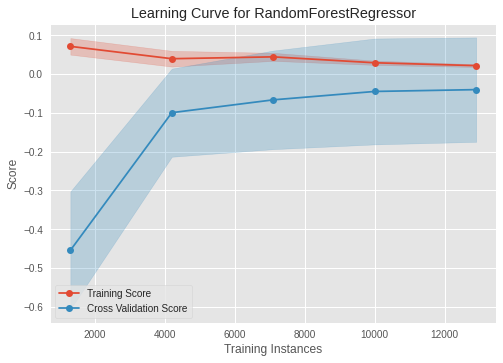

In [ ]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator= RF_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(RF, y_RF)
visualizer.show()   

In [ ]:
# Create and train the model
RF_regr.fit(RF_train, y_RF_train)

RandomForestRegressor(max_depth=6, max_leaf_nodes=25,
                      min_impurity_decrease=0.01, min_samples_split=4,
                      random_state=123)

In [ ]:
# Explore feature importance 
formattedList = [float(format(member,'.6f')) for member in RF_regr.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in RF_regr.feature_importances_]
data_tuples = list(zip(RF.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

## Mood, appeal and speechiness are irrelevant for the prediction and discarted. 
## Unfortunately due to noise there is no good fit in the data

Feature  Coefficient  AbsCoefficient
1  instrumentalness     0.892142        0.892142
2          loudness     0.107858        0.107858
0      danceability     0.000000        0.000000
3             tempo     0.000000        0.000000
4     audio_valence     0.000000        0.000000
5     song_duration     0.000000        0.000000

In [ ]:
# predict y for X_train and X_test
y_RF_pred_train = RF_regr.predict(RF_train) 
y_RF_pred_test = RF_regr.predict(RF_test) 

In [ ]:
# Show performance results
RF_resultsDF = performanceMetricsDF(metrics, y_RF_train, y_RF_pred_train, y_RF_test, y_RF_pred_test)
RF_resultsDF

#35 and 40 iterations have almost same results when it comes to R2. 
#R2 train and test are similar, therefore the model is not overfitting.

Measure         Train          Test
0        MAE  7.781572e-01  7.867299e-01
1       RMSE  9.652025e-01  9.749587e-01
2        R^2 -3.481901e-06 -5.204656e-04
3   MAPE (%)  2.279835e+12  2.828831e+12
4  MAX Error  2.782182e+00  2.782182e+00

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



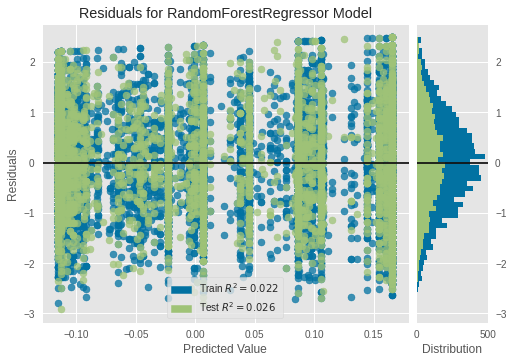

In [ ]:
# Visualize the residuals
RF_residuals_vis = ResidualsPlot(RF_regr)
RF_residuals_vis.fit(RF_train, y_RF_train)  # Fit the training data to the visualizer
RF_residuals_vis.score(RF_test, y_RF_test)  # Evaluate the model on the test data
RF_residuals_vis.show() 

### Comments on Random forest

Compared to the decision tree model, the Random Forest eventually attributed different importance levels to the original and encoded values.
Surprisingly the importnce of most attributes has been dropped to 0 and only 2 variables have been kept.  



* [6.0 - Overall evaluation](#overall)

In [ ]:
all_results =  [LR_resultsDF, DT_resultsDF, MLP_resultsDF, RF_resultsDF]
names = ['Linear model', 'Decision tree', 'Neural network', 'Random Forest']
final_data = pd.DataFrame([])

for i in range(0, len(all_results)):

    all_results[i]['Model'] =  str(names[i])
    final_data = final_data.append(all_results[i])
    



In [ ]:
## collecting the results into a unique table for comparison

table = pd.pivot_table(final_data, values=['Train', 'Test'], index=['Measure'],
                    columns=['Model'], aggfunc=np.sum)
table

Test                                             \
Model     Decision tree  Linear model Neural network Random Forest   
Measure                                                              
MAE        7.690504e-01  1.508133e-01   1.490000e-01  7.867299e-01   
MAPE (%)   1.866615e+13  1.351038e+13   1.354595e+13  2.828831e+12   
MAX Error  2.946137e+00  5.436432e-01   5.520000e-01  2.782182e+00   
RMSE       9.559281e-01  1.870737e-01   1.860000e-01  9.749587e-01   
R^2        3.815733e-02  3.647402e-02   4.800000e-02 -5.204656e-04   

                  Train                                             
Model     Decision tree  Linear model Neural network Random Forest  
Measure                                                             
MAE        7.565963e-01  1.491225e-01   1.470000e-01  7.781572e-01  
MAPE (%)   1.747066e+13  1.320838e+13   1.318950e+13  2.279835e+12  
MAX Error  2.812757e+00  5.264694e-01   5.460000e-01  2.782182e+00  
RMSE       9.408053e-01  1.848849e-01   1.830000e-01  9.652025e-01  
R^2        4.991143e-02  3.540506e-02   5.300000e-02 -3.481901e-06

# <font color = '#FF5733'>6.0 - Overall evaluation </font> <a class = "anchor" id = overall></a>

[back to content](#contents)

Although different attempts in modelling, with different models, set-ups, data prepration and feature selection, we could not find any key patterns to really predict the song popularity within this data set provided. 
<br>
 
 The neural network proved to be the best in terms of results, confidence and fitting between train and test. But still the Rsquared is really low.  <br>

All in all, we propose a full enrichment of the data in order to get better "results" in terms of popularity:

* artists name: if an artist is popular, the song will most likely be as well. Possible collaboration between two popular artists raise the probability even more.
* year of release: popularity should be compared on songs with same "maturity of release"
* genre: different genres have differnt potential to become popular and different features among the popular ones. A raggaeton song cannot have the same features of a white soul, and still be both positive
* extra features of the song, especially the chords and the structure of refrain and chorus
* summary of main lyrics contents

This is probably due because the popularity of the songs is probably most related to the nature of the artist, genre, release date and other variables instead of the ones used on this research. <br>
Finally, it could be interesting for future analysis having features related to Spotify users in order to understand if there's a fit or relation between the popularity of certain songs and the user characteristics.
